In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, metrics
import numpy as np
import matplotlib.pyplot as plt

In [29]:
BATCH_SIZE = 16
IMG_SIZE = 256
EPOCHS = 50
CHANNELS=3

In [3]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    "cotton",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,    
    seed=123,
    label_mode='int',                 
)

Found 1710 files belonging to 4 classes.


In [4]:
class_names=datasets.class_names
class_names

['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy']

In [5]:
len(datasets)

107

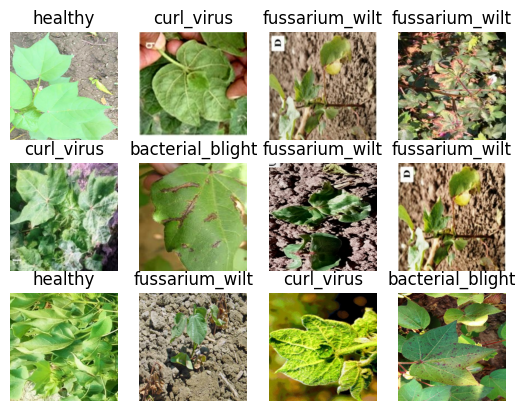

In [6]:
for image_batch, labels_batch in datasets.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
  

In [7]:
def get_dataset_partition_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train,val,test=get_dataset_partition_tf(datasets, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000)

In [9]:
len(train), len(val), len(test)

(85, 10, 12)

In [10]:
train=train.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val=val.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test=test.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [11]:
train, val, test

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [12]:
from tensorflow.keras import layers

In [88]:
resize_and_scale=tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1./255),
])

In [89]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [55]:
train = train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [74]:
n_classes=4
input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)

In [ ]:
model=models.Sequential([
    resize_and_scale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4)
])

In [92]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(256, 256),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])


In [93]:
model.summary()

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_4 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_173 (Conv2D)             │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_173               │ (None, 128, 128, 64)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_174 (Conv2D)             │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_174               │ (None, 64, 64, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_175               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_176               │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_177 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_177               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_178 (Conv2D)             │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_178               │ (None, 4, 4, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,148 (1.21 MB)

 Trainable params: 318,148 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history = model.fit(train, validation_data=val, epochs=EPOCHS)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 61s 688ms/step - accuracy: 0.4067 - loss: 1.2762 - val_accuracy: 0.7500 - val_loss: 0.6725
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 65s 754ms/step - accuracy: 0.6334 - loss: 0.8816 - val_accuracy: 0.6875 - val_loss: 0.7786
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 58s 670ms/step - accuracy: 0.7062 - loss: 0.7670 - val_accuracy: 0.7625 - val_loss: 0.5868
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 56s 649ms/step - accuracy: 0.7479 - loss: 0.6915 - val_accuracy: 0.7875 - val_loss: 0.5754
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 65s 759ms/step - accuracy: 0.7654 - loss: 0.6489 - val_accuracy: 0.7750 - val_loss: 0.5616
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 66s 769ms/step - accuracy: 0.7573 - loss: 0.6117 - val_accuracy: 0.7750 - val_loss: 0.6122
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 739ms/step - accuracy: 0.7875 - loss: 0.5767 - val_accuracy: 0.7500 - val_loss: 0.7083
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 61s 709ms/step - accuracy: 0.7427 - loss: 0.6745 - val_accu

In [ ]:
score=model.evaluate(test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9954 - loss: 0.0251


In [ ]:
np.argmax(model.predict(test), axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


array([3, 0, 3, 1, 2, 1, 0, 1, 0, 3, 0, 0, 1, 0, 0, 2, 2, 2, 3, 1, 1, 2,
       3, 3, 2, 2, 1, 0, 0, 3, 1, 1, 1, 0, 0, 3, 1, 2, 0, 2, 3, 2, 2, 2,
       3, 2, 1, 3, 1, 0, 2, 2, 3, 1, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 1, 0,
       2, 0, 3, 1, 0, 0, 3, 1, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 3, 3, 1, 2,
       1, 3, 3, 0, 0, 1, 0, 2, 1, 1, 3, 0, 1, 3, 1, 1, 1, 2, 3, 0, 0, 0,
       2, 2, 1, 2, 1, 3, 0, 2, 2, 3, 0, 2, 1, 0, 3, 2, 2, 0, 1, 3, 1, 1,
       1, 2, 0, 3, 3, 2, 3, 3, 3, 0, 3, 3, 1, 3, 2, 3, 0, 0, 1, 3, 1, 0,
       0, 1, 1, 3, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 3, 2, 1, 1, 3, 3, 3, 2,
       2, 1, 1, 2, 3, 2, 2, 2, 0, 0, 3, 0, 2, 0, 2, 0], dtype=int64)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


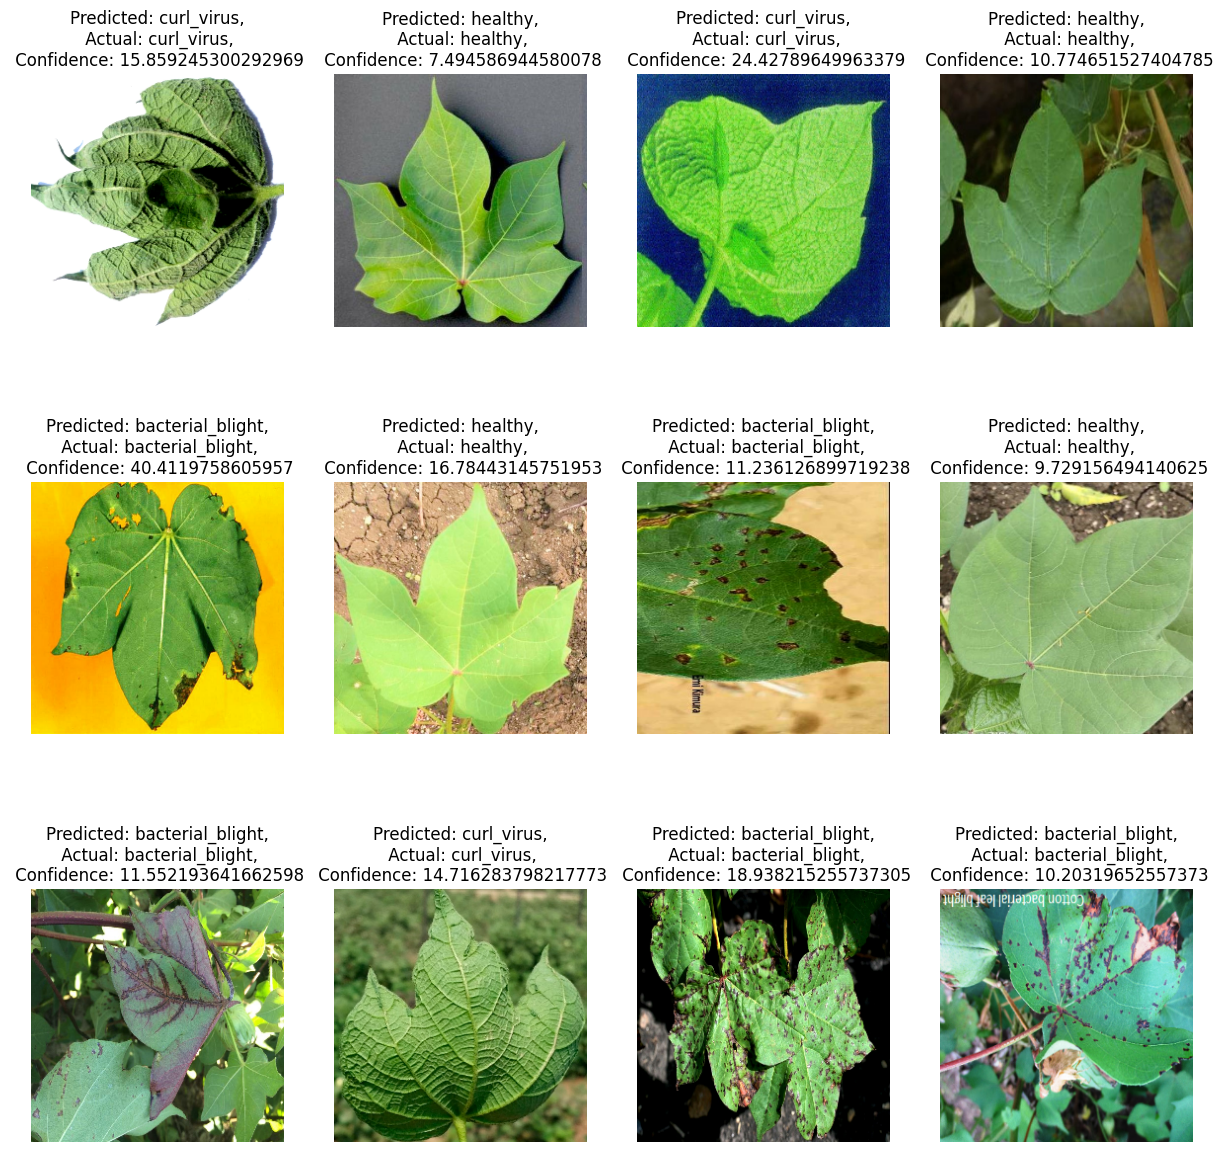

In [ ]:
plt.figure(figsize=(15, 15))
for images,labels in datasets.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {class_names[np.argmax(model.predict(images[i][tf.newaxis]))]},\n Actual: {class_names[labels[i]]},\n Confidence: {np.max(model.predict(images[i][tf.newaxis]))}")
        plt.axis("off")